## Import Necessary Packages

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

import os
import sys
import matplotlib.pyplot as plt

## Check for GPU

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Create The Custom Linear Quantization Function

In [17]:
class Quantizer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, n_bits):
        """Quantizes the input x to n_bits precision."""
        qmin, qmax = 0, 2 ** n_bits - 1
        scale = (x.max() - x.min()) / (qmax - qmin)
        x_q = torch.round(x / scale).clamp(qmin, qmax) * scale
        return x_q

    @staticmethod
    def backward(ctx, grad_output):
        """Straight-through estimator for gradient computation."""
        return grad_output, None


## Integrate into EdgePtychoNN

In [18]:
class ReconSmallPhaseModel(nn.Module):
    def __init__(self, nconv: int = 16, n_bits: int = 8):
        super(ReconSmallPhaseModel, self).__init__()
        self.nconv = nconv
        self.n_bits = n_bits  # Number of bits for quantization
        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
            *self.down_block(1, self.nconv),
            *self.down_block(self.nconv, self.nconv * 2),
            *self.down_block(self.nconv * 2, self.nconv * 4),
            *self.down_block(self.nconv * 4, self.nconv * 8), 
            *self.down_block(self.nconv * 8, self.nconv * 16), 
            *self.down_block(self.nconv * 16, self.nconv * 32),
            #*self.down_block(self.nconv * 32, self.nconv * 32)
        )
        
        # amplitude model
        #self.decoder1 = nn.Sequential(
            #*self.up_block(self.nconv * 32, self.nconv * 32),
         #   *self.up_block(self.nconv * 32, self.nconv * 16),
          #  *self.up_block(self.nconv * 16, self.nconv * 8),
           # *self.up_block(self.nconv * 8, self.nconv * 8),
            #*self.up_block(self.nconv * 8, self.nconv * 4),
            #*self.up_block(self.nconv * 4, self.nconv * 2),
            #*self.up_block(self.nconv * 2, self.nconv * 1),
            #nn.Conv2d(self.nconv * 1, 1, 3, stride=1, padding=(1,1)),
        #)
        
        # phase model
        self.decoder2 = nn.Sequential(
            #*self.up_block(self.nconv * 32, self.nconv * 32),
            *self.up_block(self.nconv * 32, self.nconv * 16),
            *self.up_block(self.nconv * 16, self.nconv * 8),
            *self.up_block(self.nconv * 8, self.nconv * 8),
            *self.up_block(self.nconv * 8, self.nconv * 4),
            *self.up_block(self.nconv * 4, self.nconv * 2),
            *self.up_block(self.nconv * 2, self.nconv * 1),
            nn.Conv2d(self.nconv * 1, 1, 3, stride=1, padding=(1,1)),
            nn.Tanh()
        )
    def down_block(self, filters_in, filters_out):
        block = [
            nn.Conv2d(in_channels=filters_in, out_channels=filters_out, kernel_size=3, stride=1, padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(filters_out, filters_out, 3, stride=1, padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d((2,2))
        ]
        return block
    
    
    def up_block(self, filters_in, filters_out):
        block = [
            nn.Conv2d(filters_in, filters_out, 3, stride=1, padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(filters_out, filters_out, 3, stride=1, padding=(1,1)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear')
        ]
        return block
        
    
    def forward(self,x):
        with torch.cuda.amp.autocast():
            x = Quantizer.apply(x,self.n_bits)    # Apply quantization to input
            #print("Data type after quantization of inputs:", x.dtype)   # Print the data type after quantization
            
            x1 = self.encoder(x)
            x1 = Quantizer.apply(x1, self.n_bits) # Quantize feature maps
            #print("Size after encoder:", x1.size())  # Print size after encoder
            #print("Type after encoder:", x1.dtype)   # Print the data type after quantization

            #amp = self.decoder1(x1)
            ph = self.decoder2(x1)
            ph = Quantizer.apply(ph, self.n_bits)  #Quantize output

            #Restore -pi to pi range
            ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi
            
        return ph

## Get Data From Scan Files

In [19]:
class PtychographyDataset(Dataset):
    def __init__(self, npz_files):

        # Initialize empty lists for inputs and labels from all files
        all_inputs = []
        all_labels = []

        # Loop through all 10 files
        for npz_file in npz_files:
            data = np.load(npz_file)
            inputs = torch.tensor(data["reciprocal"], dtype=torch.float32)
            labels = np.angle(data["real"])
            labels = torch.tensor(labels, dtype=torch.float32)

            # Ensure input and label shapes are correct 
            if len(inputs.shape) == 3:  
                inputs = inputs.unsqueeze(1)  # Add channel dim (C=1)
                labels = labels.unsqueeze(1)  # Add channel dim (C=1)

            # Append the data from file to lists
            all_inputs.append(inputs)
            all_labels.append(labels)

        # Concatenate all data 
        self.inputs = torch.cat(all_inputs, dim = 0)
        self.labels = torch.cat(all_labels, dim = 0)


    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

## Train Quantized Model

In [20]:
# List of file paths
npz_files = [
    "/home/sfowler/Downloads/NewScans/scan674.npz", "/home/sfowler/Downloads/NewScans/scan683.npz", "/home/sfowler/Downloads/NewScans/scan692.npz", 
    "/home/sfowler/Downloads/NewScans/scan701.npz", "/home/sfowler/Downloads/NewScans/scan710.npz", "/home/sfowler/Downloads/NewScans/scan720.npz", 
    "/home/sfowler/Downloads/NewScans/scan730.npz", "/home/sfowler/Downloads/NewScans/scan740.npz", "/home/sfowler/Downloads/NewScans/scan750.npz", 
    "/home/sfowler/Downloads/NewScans/scan760.npz", "/home/sfowler/Downloads/NewScans/scan770.npz"
]

#807, 810, 816

# Load dataset
train_dataset = PtychographyDataset(npz_files)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model
model = ReconSmallPhaseModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# criterion = nn.MSELoss()  #First Loss I tried
criterion = nn.L1Loss() # Changed Loss 

## Load Model State

In [21]:
def load_state(model, optimizer, filename="checkpoint_q.pth"):
#def load_state(model, optimizer, scheduler, filename="checkpoint_q.pth"):
    state = torch.load(filename)
    
    model.load_state_dict(state['model_state_dict'])
    optimizer.load_state_dict(state['optimizer_state_dict'])
    #scheduler.load_state_dict(state['scheduler_state_dict'])
    
    start_epoch = state['epoch'] + 1  # Resume from the next epoch
    loss = state['loss']
    
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
    #return model, optimizer, scheduler, start_epoch, loss
    return model, optimizer, start_epoch, loss

## Save Model State

In [22]:
def save_state(model, optimizer, epoch, loss, filename="checkpoint_q.pth"):
#def save_state(model, optimizer, scheduler, epoch, loss, filename="checkpoint_q.pth"):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        #'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss
    }
    torch.save(state, filename)
    print(f"Checkpoint saved at epoch {epoch}")

## Define Training Loop

In [23]:
def train(model, train_loader, criterion, optimizer, start_epoch, num_epochs, device):
#def train(model, train_loader, criterion, optimizer, scheduler, start_epoch, num_epochs, device):
    model.train()  # Set model to training mode
    for epoch in range(start_epoch, start_epoch + num_epochs):
        running_loss = 0.0  # Track total loss for the epoch
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available

            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass

            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            running_loss += loss.item()  # Accumulate loss

        #scheduler.step()
        avg_loss = running_loss / len(train_loader)  # Compute average loss per batch
        print(f"Epoch [{epoch+1}/{start_epoch + num_epochs}], Ave Loss: {avg_loss:.5f}, Loss: {loss.item():.5f}, Learning Rate: {optimizer.param_groups[0]['lr']}")

        final_loss = loss # Update final loss to the current epochs average loss

    print("Training complete.")
    return final_loss

## Train Model

In [73]:
checkpoint_path = "checkpoint_q.pth"

# If there's a checkpoint, load it.
if os.path.exists(checkpoint_path):
    model, optimizer, start_epoch, last_loss = load_state(model, optimizer, checkpoint_path)
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0
    print(f"Starting fresh training from epoch {start_epoch}")

# Define the total number of epochs you want to train in this run.
num_epochs = 40

final_loss = train(model, train_loader, criterion, optimizer, start_epoch, num_epochs, device)

final_epoch = start_epoch + num_epochs - 1  # last epoch trained in this run

save_state(model, optimizer, final_epoch, final_loss, filename=checkpoint_path)

/tmp/ipykernel_180955/517364181.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(filename)
/tmp/ipykernel_180955/2951712598.py:63: FutureWarning: `torc

Checkpoint loaded. Resuming from epoch 160
Resuming training from epoch 160
Epoch [161/200], Ave Loss: 0.47128, Loss: 0.54261, Learning Rate: 0.0001
Epoch [162/200], Ave Loss: 0.47017, Loss: 0.30607, Learning Rate: 0.0001
Epoch [163/200], Ave Loss: 0.47064, Loss: 0.32146, Learning Rate: 0.0001
Epoch [164/200], Ave Loss: 0.46974, Loss: 0.43040, Learning Rate: 0.0001
Epoch [165/200], Ave Loss: 0.47061, Loss: 0.62310, Learning Rate: 0.0001
Epoch [166/200], Ave Loss: 0.47024, Loss: 0.43944, Learning Rate: 0.0001
Epoch [167/200], Ave Loss: 0.46974, Loss: 0.52816, Learning Rate: 0.0001
Epoch [168/200], Ave Loss: 0.46900, Loss: 0.48463, Learning Rate: 0.0001
Epoch [169/200], Ave Loss: 0.46980, Loss: 0.58560, Learning Rate: 0.0001
Epoch [170/200], Ave Loss: 0.46921, Loss: 0.50255, Learning Rate: 0.0001
Epoch [171/200], Ave Loss: 0.46884, Loss: 0.63184, Learning Rate: 0.0001
Epoch [172/200], Ave Loss: 0.46932, Loss: 0.65731, Learning Rate: 0.0001
Epoch [173/200], Ave Loss: 0.46856, Loss: 0.5603

## Realize Images

Output Stats - Min: 0.0 Max: 1.008270263671875 Mean: 0.35178515315055847


/tmp/ipykernel_180955/2951712598.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


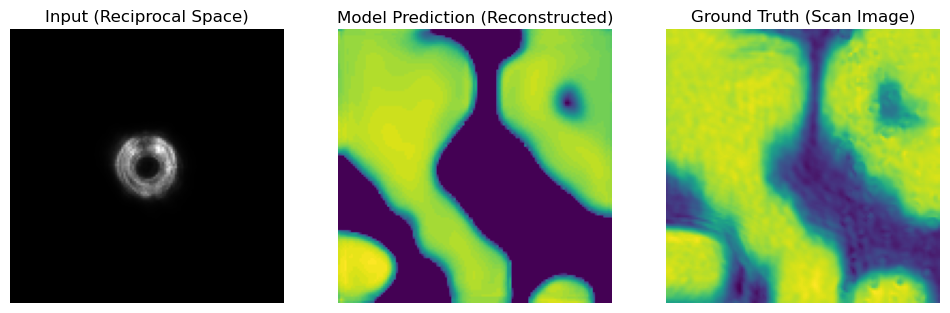

Output Stats - Min: 0.0 Max: 1.008270263671875 Mean: 0.35178515315055847


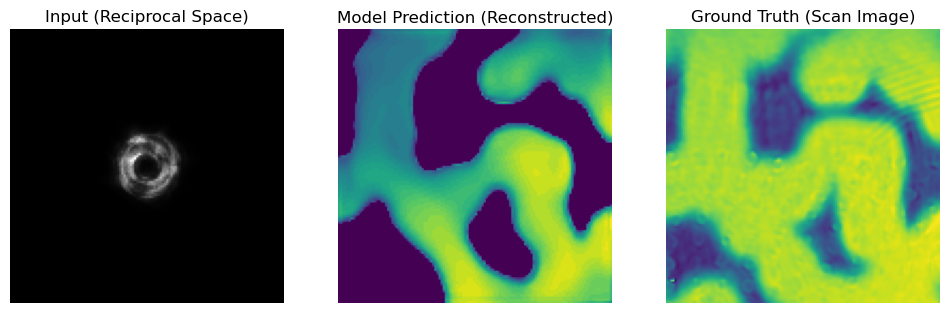

Output Stats - Min: 0.0 Max: 1.008270263671875 Mean: 0.35178515315055847


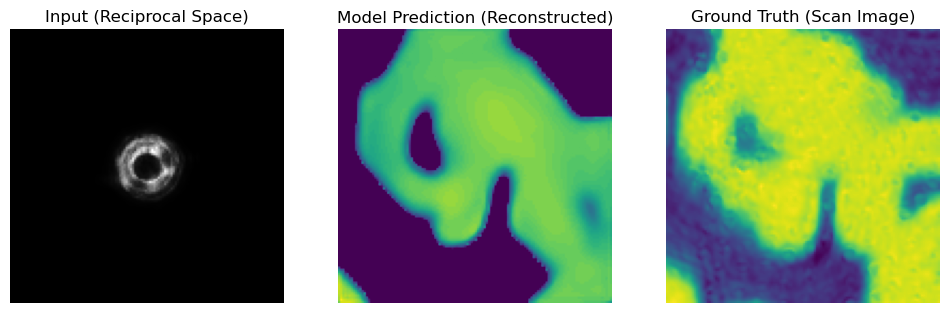

In [74]:
def normalize_image(image):
    min_val, max_val = image.min(), image.max()
    return (image - min_val) / (max_val - min_val) if max_val > min_val else image

def visualize_prediction(model, dataloader, num_samples=1):
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in dataloader:  # Get a batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Model's predicted image
            break  # Only take the first batch

    for i in range(num_samples):  # Loop through first few samples
        print("Output Stats - Min:", outputs.min().item(), "Max:", outputs.max().item(), "Mean:", outputs.mean().item())

        plt.figure(figsize=(12, 4))

        # Original scan (Ground Truth)
        plt.subplot(1, 3, 1)
        plt.imshow(inputs[i, 0].cpu().numpy(), cmap="gray")
        plt.title("Input (Reciprocal Space)")
        plt.axis("off")

        # Model Prediction
        plt.subplot(1, 3, 2)
        plt.imshow(outputs[i, 0].cpu().numpy(), cmap="viridis")
        plt.title("Model Prediction (Reconstructed)")
        plt.axis("off")

        # Ground Truth
        plt.subplot(1, 3, 3)
        plt.imshow(labels[i, 0].cpu().numpy(), cmap="viridis")
        plt.title("Ground Truth (Scan Image)")
        plt.axis("off")

        plt.show()

# Run visualization
visualize_prediction(model, train_loader, num_samples=3)

## GPU Training Loop

In [35]:
# Define model
model = ReconSmallPhaseModel().to(device)

# Define loss function 
criterion = nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

# Number of epochs
num_epochs = 1

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():  # Enables mixed precision
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()  # Scale loss for stability
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Final quantization
for param in model.parameters():
    param.data = Quantizer.apply(param.data, 8)  

# Save trained model
torch.save(model.state_dict(), "quantized_model.pth")



Epoch [1/1], Loss: 0.0565


## Test the Model

In [10]:
npz_file = ["/home/sfowler/Downloads/NewScans/scan780.npz"]
checkpoint_path = "checkpoint_q.pth"

dataset = PtychographyDataset(npz_file)

# If there's a checkpoint, load it.
if os.path.exists(checkpoint_path):
    model, optimizer, start_epoch, last_loss = load_state(model, optimizer, checkpoint_path)
    print(f"Beginning Training")
else:
    start_epoch = 0
    print(f"Starting fresh training from epoch {start_epoch}")

# Set the model to evaluation mode
model.eval()

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

# Define a loss function for evaluation 
criterion = nn.L1Loss()

# Initialize variables for tracking performance
total_loss = 0
num_batches = 0

# Iterate over the test data
with torch.no_grad():  # Disable gradient computation during testing
    for inputs, labels in test_dataloader:
        # Forward pass through the model
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        num_batches += 1


        # Visualize the first image in the batch
        # Assuming the outputs and labels are 2D (images), take the first sample
        output_image = outputs[0].cpu().numpy()
        label_image = labels[0].cpu().numpy()

        # Plot the images (original vs predicted)
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        
        ax[0].imshow(label_image[0], cmap='viridis')  # Assuming the images are single channel (grayscale)
        ax[0].set_title("Ground Truth")
        ax[0].axis('off')

        ax[1].imshow(output_image[0], cmap='viridis')  # Model output
        ax[1].set_title("Predicted Output")
        ax[1].axis('off')

        plt.show()

# Compute average loss
average_loss = total_loss / num_batches
print(f"Average loss on test set: {average_loss}")


NameError: name 'model' is not defined

## Output Quantized Weights

In [11]:
checkpoint_path = "checkpoint_q.pth"

# If there's a checkpoint, load it.
if os.path.exists(checkpoint_path):
    model, optimizer, start_epoch, last_loss = load_state(model, optimizer, checkpoint_path)
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0
    print(f"Starting fresh training from epoch {start_epoch}")

for param in model.parameters():
    param.data = Quantizer.apply(param.data, 8)  # Apply final quantization

torch.save(model, "quantized_model.pth")


Checkpoint loaded. Resuming from epoch 200
Resuming training from epoch 200


## Check the Model Path

In [14]:
import torch

model = torch.load("quantized_model.pth")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)

print("The number of parameters in this file is:", num_params)

The number of parameters in this file is: 7371745
